# The effect of speed humps on collision rates

The objective of this notebook is to visualize and measure the effect speed humps have on collision rates in New York City. When looking at collision data from NYC in a previous notebook, I noticed that roads with speed humps did not necesasrily have a lower collision rate than those without them. This may presumably be explained by the observation that most roads that do not have speed humps are safer roads in the first place: speed humps are usually installed when there is a reason to install them. It would be obviously wrong to conclude that speed humps have no effect on road safety, but a different strategy is needed to measure their impact.

In this notebook, I will focus on roads which currently have speed humps and will compare their weekly collision rates before and after the speed humps were installed. This approach does yield the expected result: speed humps do reduce collision rates. Moreover, it appears that the relationship between the weekly collision rates before and after speed humps were installed is roughly linear.

### Data preparation

This section prepares the data that will be needed and saves it in the `data` folder. Here's what I will do:

1. I will assign each crash in NYC to a road.
1. I will assign each road to a road section the speed humps dataset. Unlike the road sections in the `centerline` dataset, the speed humps dataset road sections do not terminate at intersections. In most cases, they correspond to several blocks. In this assignment process, I will only keep roads that find a match in the speed humps dataset, i.e. roads that have speed humps.
1. Since we should ensure that we have enough data to calculate a weekly collision rate, I will ignore roads whose speed humps were installed within one year from today or within one year from the date of the first crash reported in the collisions dataset.
1. I will create a seperate dataset only with collisions involving pedestrians.
1. After aggreagting the results to count the number and rate of collisions per street, we need to make sure that every street where a collision occurred appears twice: once before and once after the installation of the speed humps.

In [1]:
import sys

sys.path.insert(0, "../")

In [2]:
from data_downloader import OpenDataDownloader

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

nyc_app_token = os.getenv("NYC_OPENDATA_APPTOKEN")

In [4]:
data_loader = OpenDataDownloader(nyc_app_token)

In [5]:
import data_sources
import geo

humps = data_loader.load_geo_dataframe(
    data_sources.SPEEDHUMPS_ENDPOINT,
    geometry_column="the_geom",
    to_crs=geo.NYC_EPSG,
    limit=3000000,
)
crashes = data_loader.load_data(data_sources.CRASHES_ENDPOINT, limit=3000000)
centerline = data_loader.load_geo_dataframe(
    data_sources.CENTERLINE_ENDPOINT,
    geometry_column="the_geom",
    to_crs=geo.NYC_EPSG,
    limit=3000000,
)

In [ ]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077598 entries, 0 to 2077597
Data columns (total 29 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   crash_date                     object
 1   crash_time                     object
 2   on_street_name                 object
 3   off_street_name                object
 4   number_of_persons_injured      object
 5   number_of_persons_killed       object
 6   number_of_pedestrians_injured  object
 7   number_of_pedestrians_killed   object
 8   number_of_cyclist_injured      object
 9   number_of_cyclist_killed       object
 10  number_of_motorist_injured     object
 11  number_of_motorist_killed      object
 12  contributing_factor_vehicle_1  object
 13  contributing_factor_vehicle_2  object
 14  collision_id                   object
 15  vehicle_type_code1             object
 16  vehicle_type_code2             object
 17  borough                        object
 18  zip_code              

In [ ]:
crashes_short = crashes[
    [
        "collision_id",
        "crash_date",
        "number_of_pedestrians_injured",
        "number_of_pedestrians_killed",
        "longitude",
        "latitude",
    ]
].copy()

In [ ]:
import numpy as np

crashes_short["crash_date"] = crashes_short["crash_date"].apply(np.datetime64)

In [ ]:
crashes_short.dropna(subset=["longitude", "latitude"], inplace=True)

In [ ]:
import geopandas as gpd

crashes_short = gpd.GeoDataFrame(
    crashes_short,
    geometry=gpd.points_from_xy(crashes_short["longitude"], crashes_short["latitude"]),
    crs=geo.STD_EPSG,
).to_crs(geo.NYC_EPSG)

In [ ]:
crashes_short.head()

,collision_id,crash_date,number_of_pedestrians_injured,number_of_pedestrians_killed,longitude,latitude,geometry
3,4456314,2021-09-11,0,0,-73.8665,40.667202,POINT (1021285.187 182384.298)
4,4486609,2021-12-14,0,0,-73.917274,40.683304,POINT (1007194.075 188233.330)
6,4486555,2021-12-14,0,0,-73.956825,40.709183,POINT (996219.950 197653.931)
7,4486660,2021-12-14,0,0,-73.83148,40.86816,POINT (1030859.472 255616.610)
8,4487074,2021-12-14,0,0,-73.8971,40.67172,POINT (1012794.294 184018.878)


In [ ]:
centerline_short = centerline[["physicalid", "shape_leng", "geometry"]].copy()

In [ ]:
centerline_short["buffered"] = centerline_short["geometry"].buffer(25)
centerline_short.rename(
    columns={
        "buffered": "geometry",
        "geometry": "road_geom",
        "shape_leng": "road_leng",
    },
    inplace=True,
)

In [ ]:
crashes_road = crashes_short.sjoin(centerline_short, how="left", predicate="within")

In [ ]:
crashes_road.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5814357 entries, 3 to 2077597
Data columns (total 11 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   collision_id                   object        
 1   crash_date                     datetime64[ns]
 2   number_of_pedestrians_injured  object        
 3   number_of_pedestrians_killed   object        
 4   longitude                      object        
 5   latitude                       object        
 6   geometry                       geometry      
 7   index_right                    float64       
 8   physicalid                     object        
 9   road_leng                      object        
 10  road_geom                      geometry      
dtypes: datetime64[ns](1), float64(1), geometry(2), object(7)
memory usage: 532.3+ MB


In [ ]:
crashes_road.rename(
    columns={"road_geom": "geometry", "geometry": "crash_location"}, inplace=True
)

In [ ]:
crashes_road = crashes_road[
    [
        "crash_date",
        "number_of_pedestrians_injured",
        "number_of_pedestrians_killed",
        "geometry",
        "physicalid",
        "road_leng",
        "crash_location",
        "collision_id",
    ]
].copy()

In [ ]:
humps.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3763 entries, 0 to 3762
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   on_street   3763 non-null   object  
 1   from_stree  3763 non-null   object  
 2   to_street   3762 non-null   object  
 3   humps       3763 non-null   object  
 4   date_insta  3763 non-null   object  
 5   shape_leng  3763 non-null   object  
 6   geometry    3763 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 205.9+ KB


In [ ]:
humps["geometry"] = humps["geometry"].buffer(25)

In [ ]:
crashes_hump_roads = crashes_road.sjoin(humps, how="inner", predicate="within")

In [ ]:
crashes_hump_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 327394 entries, 3 to 2077584
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_date                     327394 non-null  datetime64[ns]
 1   number_of_pedestrians_injured  327394 non-null  object        
 2   number_of_pedestrians_killed   327394 non-null  object        
 3   geometry                       327394 non-null  geometry      
 4   physicalid                     327394 non-null  object        
 5   road_leng                      327394 non-null  object        
 6   crash_location                 327394 non-null  geometry      
 7   collision_id                   327394 non-null  object        
 8   index_right                    327394 non-null  int64         
 9   on_street                      327394 non-null  object        
 10  from_stree                     327394 non-null  object        
 

In [ ]:
crashes_hump_roads = crashes_hump_roads[
    [
        "crash_date",
        "number_of_pedestrians_injured",
        "number_of_pedestrians_killed",
        "geometry",
        "physicalid",
        "road_leng",
        "humps",
        "date_insta",
        "shape_leng",
        "collision_id",
    ]
].copy()

In [ ]:
startdate = crashes_hump_roads["crash_date"].min()

In [ ]:
startdate

Timestamp('2012-07-01 00:00:00')

In [ ]:
crashes_hump_roads["date_insta"] = crashes_hump_roads["date_insta"].apply(np.datetime64)

There are a few roads duplicated in the `centerline` dataset and their corresponding shapes have slightly different lengths. Here I want to have at most two rows per road (one for collisions before speed humps, and another for collisions after speed humps), so I chose to aggregate by taking the maximum of those lengths. A similar comment also applies to data regarding speed humps.

In [ ]:
road_info = crashes_hump_roads.groupby(by=["physicalid"], as_index=False).agg(
    {"humps": "max", "shape_leng": "max", "road_leng": "max", "date_insta": "max"}
)

crashes_hump_roads = crashes_hump_roads.merge(
    road_info, how="left", on="physicalid", suffixes=["_old", ""]
).drop(columns=["humps_old", "shape_leng_old", "date_insta_old", "road_leng_old"])

In [ ]:
crashes_hump_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 327394 entries, 0 to 327393
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_date                     327394 non-null  datetime64[ns]
 1   number_of_pedestrians_injured  327394 non-null  object        
 2   number_of_pedestrians_killed   327394 non-null  object        
 3   geometry                       327394 non-null  geometry      
 4   physicalid                     327394 non-null  object        
 5   collision_id                   327394 non-null  object        
 6   humps                          327394 non-null  object        
 7   shape_leng                     327394 non-null  object        
 8   road_leng                      327394 non-null  object        
 9   date_insta                     327394 non-null  datetime64[ns]
dtypes: datetime64[ns](2), geometry(1), object(7)
memory usage: 2

In [ ]:
chr_2013 = crashes_hump_roads[
    (crashes_hump_roads["date_insta"] > startdate + np.timedelta64(365, "D"))
    & (
        crashes_hump_roads["date_insta"]
        < np.datetime64("today") + np.timedelta64(-365, "D")
    )
].copy()

In [ ]:
chr_2013.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 176875 entries, 0 to 327390
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_date                     176875 non-null  datetime64[ns]
 1   number_of_pedestrians_injured  176875 non-null  object        
 2   number_of_pedestrians_killed   176875 non-null  object        
 3   geometry                       176875 non-null  geometry      
 4   physicalid                     176875 non-null  object        
 5   collision_id                   176875 non-null  object        
 6   humps                          176875 non-null  object        
 7   shape_leng                     176875 non-null  object        
 8   road_leng                      176875 non-null  object        
 9   date_insta                     176875 non-null  datetime64[ns]
dtypes: datetime64[ns](2), geometry(1), object(7)
memory usage: 14.8+ 

In [ ]:
chr_2013["number_of_pedestrians_injured"] = (
    chr_2013["number_of_pedestrians_injured"].fillna(value=0).astype(int)
)
chr_2013["number_of_pedestrians_killed"] = (
    chr_2013["number_of_pedestrians_killed"].fillna(value=0).astype(int)
)

chr_2013["number_of_pedestrians_involved"] = (
    chr_2013["number_of_pedestrians_injured"] + chr_2013["number_of_pedestrians_killed"]
)
chr_2013["pedestrians_involved"] = chr_2013["number_of_pedestrians_involved"] > 0

In [ ]:
chr_2013["after_humps"] = chr_2013["date_insta"] < chr_2013["crash_date"]

In [ ]:
chr_2013.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 176875 entries, 0 to 327390
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   crash_date                      176875 non-null  datetime64[ns]
 1   number_of_pedestrians_injured   176875 non-null  int64         
 2   number_of_pedestrians_killed    176875 non-null  int64         
 3   geometry                        176875 non-null  geometry      
 4   physicalid                      176875 non-null  object        
 5   collision_id                    176875 non-null  object        
 6   humps                           176875 non-null  object        
 7   shape_leng                      176875 non-null  object        
 8   road_leng                       176875 non-null  object        
 9   date_insta                      176875 non-null  datetime64[ns]
 10  number_of_pedestrians_involved  176875 non-null  int6

In [ ]:
chr_2013["humps"] = chr_2013["humps"].astype(float)
chr_2013["shape_leng"] = chr_2013["shape_leng"].astype(float)
chr_2013["road_leng"] = chr_2013["road_leng"].astype(float)

In [ ]:
chr_2013_pedestrians = (
    chr_2013[chr_2013["pedestrians_involved"]]
    .copy()
    .drop(columns="pedestrians_involved")
)

In [ ]:
crashes_per_road_pedestrians = chr_2013_pedestrians.groupby(
    by=["physicalid", "after_humps"], as_index=False
).agg(
    {
        "number_of_pedestrians_injured": "sum",
        "number_of_pedestrians_killed": "sum",
        "number_of_pedestrians_involved": "sum",
        "collision_id": "count",
        "humps": "max",
        "shape_leng": "max",
        "date_insta": "max",
        "road_leng": "max",
    }
)

crashes_per_road = chr_2013.groupby(
    by=["physicalid", "after_humps"], as_index=False
).agg(
    {
        "collision_id": "count",
        "humps": "max",
        "shape_leng": "max",
        "date_insta": "max",
        "road_leng": "max",
    }
)

crashes_per_road = crashes_per_road.rename(columns={"collision_id": "collisions"})
crashes_per_road_pedestrians = crashes_per_road_pedestrians.rename(
    columns={"collision_id": "collisions"}
)

In [ ]:
crashes_per_road.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   physicalid   5413 non-null   object        
 1   after_humps  5413 non-null   bool          
 2   collisions   5413 non-null   int64         
 3   humps        5413 non-null   float64       
 4   shape_leng   5413 non-null   float64       
 5   date_insta   5413 non-null   datetime64[ns]
 6   road_leng    5413 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 259.1+ KB


In [ ]:
import pandas as pd


def get_incidents_per_week(
    row: pd.DataFrame, initial_date: np.datetime64, incident_col_name: str
) -> pd.Series:
    if row["after_humps"]:
        n_weeks = (np.datetime64("today") - row["date_insta"]) / np.timedelta64(1, "W")
    else:
        n_weeks = (row["date_insta"] - initial_date) / np.timedelta64(1, "W")
    return row[incident_col_name] / n_weeks

In [ ]:
initial_date = np.datetime64(startdate)

crashes_per_road["collisions_per_week"] = crashes_per_road[
    ["after_humps", "date_insta", "collisions"]
].apply(lambda o: get_incidents_per_week(o, initial_date, "collisions"), axis=1)
crashes_per_road_pedestrians["collisions_per_week"] = crashes_per_road_pedestrians[
    ["after_humps", "date_insta", "collisions"]
].apply(lambda o: get_incidents_per_week(o, initial_date, "collisions"), axis=1)

In [ ]:
crashes_per_road.head()

,physicalid,after_humps,collisions,humps,shape_leng,date_insta,road_leng,collisions_per_week
0,10000,False,22,1.0,254.863422,2015-09-11,254.863378,0.131962
1,10000,True,11,1.0,254.863422,2015-09-11,254.863378,0.024616
2,100024,False,13,2.0,981.885023,2018-06-15,981.885150,0.041839
3,100024,True,15,2.0,981.885023,2018-06-15,981.885150,0.049528
4,100131,False,4,1.0,523.792986,2019-03-28,523.793152,0.011377


In [ ]:
crashes_per_road_pedestrians[
    "pedestrians_involved_per_week"
] = crashes_per_road_pedestrians[
    ["after_humps", "date_insta", "number_of_pedestrians_involved"]
].apply(
    lambda o: get_incidents_per_week(o, initial_date, "number_of_pedestrians_involved"),
    axis=1,
)

In [ ]:
crashes_per_road_pedestrians.head()

,physicalid,after_humps,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_pedestrians_involved,collisions,humps,shape_leng,date_insta,road_leng,collisions_per_week,pedestrians_involved_per_week
0,100024,True,3,0,3,3,2.0,981.885023,2018-06-15,981.885150,0.009906,0.009906
1,100141,True,1,0,1,1,3.0,1026.867713,2015-04-29,442.559554,0.002145,0.002145
2,100142,False,2,0,2,2,3.0,1026.867713,2015-04-29,584.308133,0.013566,0.013566
3,100142,True,1,0,1,1,3.0,1026.867713,2015-04-29,584.308133,0.002145,0.002145
4,100378,True,11,0,11,9,2.0,638.973355,2013-09-20,260.606301,0.016368,0.020005


At this point, if a road did not have any collisions before or after speed humps were installed, there will be no row reporting 0 collisions. We want to add those roads so that we can compare the collision rate evolution.

In [ ]:
roads_pedestrians = crashes_per_road_pedestrians[
    ["physicalid", "humps", "shape_leng", "road_leng", "date_insta"]
].drop_duplicates()
roads = crashes_per_road[
    ["physicalid", "humps", "shape_leng", "road_leng", "date_insta"]
].drop_duplicates()

In [ ]:
after_humps_combinations = pd.DataFrame({"after_humps": [False, True]})

In [ ]:
cross_join = roads.merge(after_humps_combinations, how="cross")
cross_join_pedestrians = roads_pedestrians.merge(after_humps_combinations, how="cross")

In [ ]:
crashes_per_road_pedestrians = cross_join_pedestrians.merge(
    crashes_per_road_pedestrians,
    how="left",
    on=["physicalid", "after_humps", "humps", "date_insta", "road_leng", "shape_leng"],
)
crashes_per_road = cross_join.merge(
    crashes_per_road,
    how="left",
    on=["physicalid", "after_humps", "humps", "date_insta", "road_leng", "shape_leng"],
)

In [ ]:
crashes_per_road.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5648 entries, 0 to 5647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   physicalid           5648 non-null   object        
 1   humps                5648 non-null   float64       
 2   shape_leng           5648 non-null   float64       
 3   road_leng            5648 non-null   float64       
 4   date_insta           5648 non-null   datetime64[ns]
 5   after_humps          5648 non-null   bool          
 6   collisions           5413 non-null   float64       
 7   collisions_per_week  5413 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(5), object(1)
memory usage: 314.5+ KB


In [ ]:
crashes_per_road_pedestrians = crashes_per_road_pedestrians.fillna(value=0)
crashes_per_road = crashes_per_road.fillna(value=0)

In [ ]:
crashes_per_road_pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4154 entries, 0 to 4153
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   physicalid                      4154 non-null   object        
 1   humps                           4154 non-null   float64       
 2   shape_leng                      4154 non-null   float64       
 3   road_leng                       4154 non-null   float64       
 4   date_insta                      4154 non-null   datetime64[ns]
 5   after_humps                     4154 non-null   bool          
 6   number_of_pedestrians_injured   4154 non-null   float64       
 7   number_of_pedestrians_killed    4154 non-null   float64       
 8   number_of_pedestrians_involved  4154 non-null   float64       
 9   collisions                      4154 non-null   float64       
 10  collisions_per_week             4154 non-null   float64       
 11  pede

In [ ]:
crashes_per_road.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5648 entries, 0 to 5647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   physicalid           5648 non-null   object        
 1   humps                5648 non-null   float64       
 2   shape_leng           5648 non-null   float64       
 3   road_leng            5648 non-null   float64       
 4   date_insta           5648 non-null   datetime64[ns]
 5   after_humps          5648 non-null   bool          
 6   collisions           5648 non-null   float64       
 7   collisions_per_week  5648 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(5), object(1)
memory usage: 314.5+ KB


In [50]:
crashes_per_road.to_csv("../data/crashes_per_road.csv", index=False)
crashes_per_road_pedestrians.to_csv(
    "../data/crashes_per_road_pedestrians.csv", index=False
)

### Data analysis

In [1]:
from pathlib import Path

# Import pandas again so that we can run this second part of the notebook independently of the first
import pandas as pd

crashes_road_path = Path("../data/crashes_per_road.csv")
crashes_road_pedestrians_path = Path("../data/crashes_per_road_pedestrians.csv")

if "crashes_per_road" not in globals() and crashes_road_path.exists():
    crashes_per_road = pd.read_csv(crashes_road_path)

if (
    "crashes_per_road_pedestrians" not in globals()
    and crashes_road_pedestrians_path.exists()
):
    crashes_per_road_pedestrians = pd.read_csv(crashes_road_pedestrians_path)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"

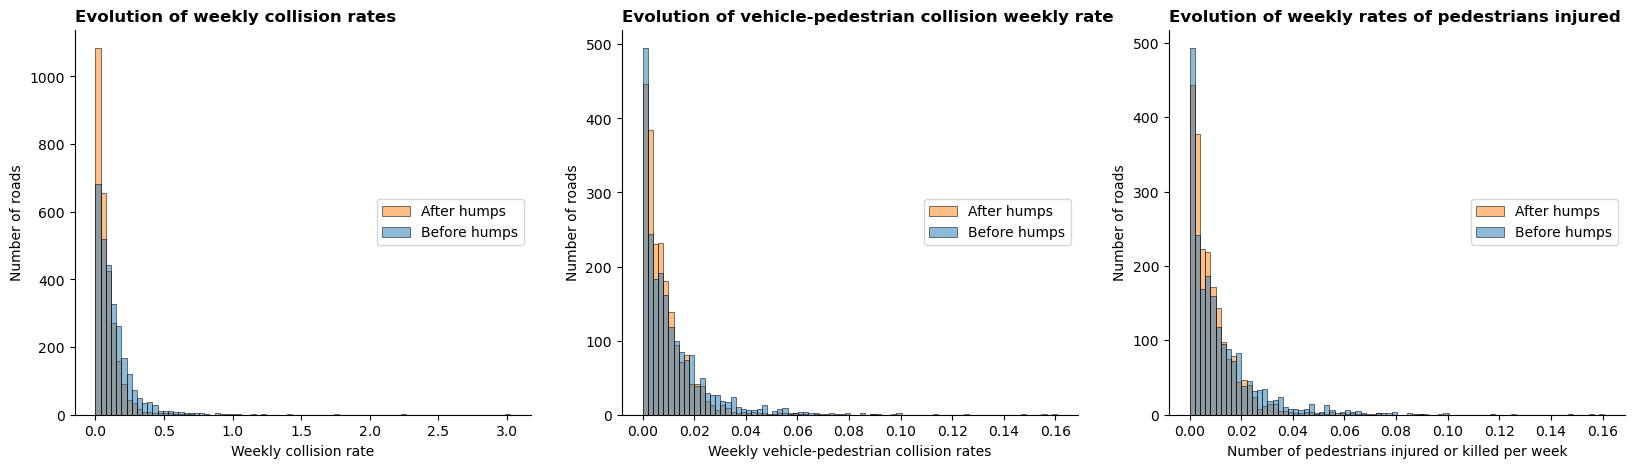

In [3]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(
    data=crashes_per_road_pedestrians,
    x="pedestrians_involved_per_week",
    hue="after_humps",
    bins=80,
    ax=ax[2],
)

sns.histplot(
    data=crashes_per_road_pedestrians,
    x="collisions_per_week",
    hue="after_humps",
    bins=80,
    ax=ax[1],
)

sns.histplot(
    data=crashes_per_road, x="collisions_per_week", hue="after_humps", bins=80, ax=ax[0]
)

ax[0].set_xlabel("Weekly collision rate")
ax[0].set_ylabel("Number of roads")
ax[0].set_title("Evolution of weekly collision rates")
ax[0].legend(["After humps", "Before humps"], loc="center right")

ax[2].set_xlabel("Number of pedestrians injured or killed per week")
ax[2].set_ylabel("Number of roads")
ax[2].set_title("Evolution of weekly rates of pedestrians injured")
ax[2].legend(["After humps", "Before humps"], loc="center right")

ax[1].set_xlabel("Weekly vehicle-pedestrian collision rates")
ax[1].set_ylabel("Number of roads")
ax[1].set_title("Evolution of vehicle-pedestrian collision weekly rate")
ax[1].legend(["After humps", "Before humps"], loc="center right")

These three histograms show the change in weekly collision/injury rates. They seem to indicate that the installation of speed humps shifts the histograms' center of mass to the left, meaning that there is a noticeable decrease in the weekly rate of collisions in general, but also in collisions involving pedestrians and the rate of pedestrian injuries (deaths included). A more convincing picture is obtained when the rate of collisions in a road after humps are installed is plotted against the rate of collisions before their installation.

In [4]:
crashes_per_road_pedestrians_before = (
    crashes_per_road_pedestrians[~crashes_per_road_pedestrians["after_humps"]]
    .drop(columns="after_humps")
    .copy()
)
crashes_per_road_pedestrians_after = (
    crashes_per_road_pedestrians[crashes_per_road_pedestrians["after_humps"]]
    .drop(columns="after_humps")
    .copy()
)

crashes_per_road_before = (
    crashes_per_road[~crashes_per_road["after_humps"]]
    .drop(columns=["after_humps"])
    .copy()
)
crashes_per_road_after = (
    crashes_per_road[crashes_per_road["after_humps"]]
    .drop(columns=["after_humps"])
    .copy()
)

In [5]:
crashes_per_road_pedestrians_before = crashes_per_road_pedestrians_before[
    [
        "physicalid",
        "humps",
        "pedestrians_involved_per_week",
        "collisions_per_week",
        "shape_leng",
    ]
]
crashes_per_road_pedestrians_after = crashes_per_road_pedestrians_after[
    [
        "physicalid",
        "humps",
        "pedestrians_involved_per_week",
        "collisions_per_week",
        "shape_leng",
    ]
]

crashes_per_road_before = crashes_per_road_before[
    [
        "physicalid",
        "humps",
        "collisions_per_week",
        "shape_leng",
    ]
]
crashes_per_road_after = crashes_per_road_after[
    [
        "physicalid",
        "humps",
        "collisions_per_week",
        "shape_leng",
    ]
]

In [6]:
crashes_pedestrians_difference = crashes_per_road_pedestrians_before.merge(
    crashes_per_road_pedestrians_after,
    on=["physicalid", "humps", "shape_leng"],
    suffixes=["_before", "_after"],
)
crashes_difference = crashes_per_road_before.merge(
    crashes_per_road_after,
    on=["physicalid", "humps", "shape_leng"],
    suffixes=["_before", "_after"],
)

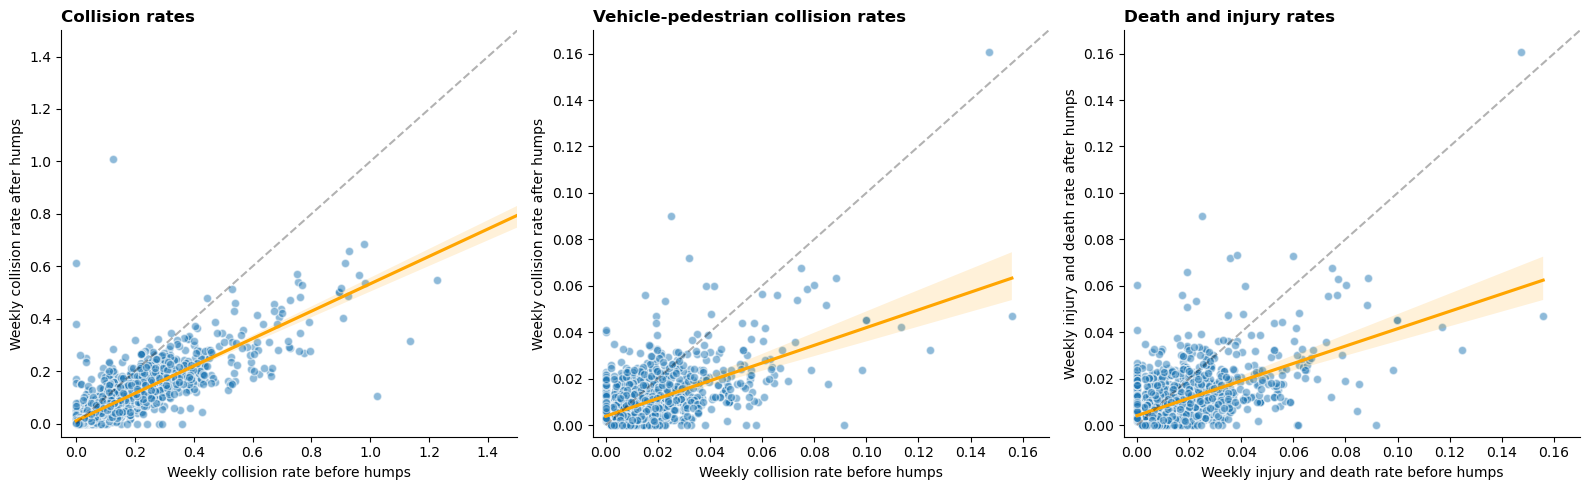

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

sns.regplot(
    data=crashes_difference,
    x="collisions_per_week_before",
    y="collisions_per_week_after",
    ax=ax[0],
    scatter_kws={"alpha": 0.5, "edgecolors": "white"},
    line_kws={"color": "orange"},
)

sns.regplot(
    data=crashes_pedestrians_difference,
    x="collisions_per_week_before",
    y="collisions_per_week_after",
    ax=ax[1],
    scatter_kws={"alpha": 0.5, "edgecolors": "white"},
    line_kws={"color": "orange"},
)

sns.regplot(
    data=crashes_pedestrians_difference,
    x="pedestrians_involved_per_week_before",
    y="pedestrians_involved_per_week_after",
    ax=ax[2],
    scatter_kws={"alpha": 0.5, "edgecolors": "white"},
    line_kws={"color": "orange"},
)

for i in range(3):
    ax[i].plot([0, 1.5], [0, 1.5], c="black", linestyle="dashed", alpha=0.3)

ax[0].set_title("Collision rates")
ax[0].set_xbound(lower=-0.05, upper=1.5)
ax[0].set_ybound(lower=-0.05, upper=1.5)
ax[0].set_xlabel("Weekly collision rate before humps")
ax[0].set_ylabel("Weekly collision rate after humps")

ax[1].set_title("Vehicle-pedestrian collision rates")
ax[1].set_xbound(lower=-0.005, upper=0.17)
ax[1].set_ybound(lower=-0.005, upper=0.17)
ax[1].set_xlabel("Weekly collision rate before humps")
ax[1].set_ylabel("Weekly collision rate after humps")

ax[2].set_title("Death and injury rates")
ax[2].set_xbound(lower=-0.005, upper=0.17)
ax[2].set_ybound(lower=-0.005, upper=0.17)
ax[2].set_xlabel("Weekly injury and death rate before humps")
ax[2].set_ylabel("Weekly injury and death rate after humps")


fig.tight_layout()

The plots above show the weekly collision or injury rates after humps were installed against the rates before their installation. Each blue dot represents a road in New York City where humps are now present (and, as mentioned before, have not been installed within one year from now or from the earliest reported crash) and at least one collision occurred between July 2012 and now. The light grey dashed line is the diagonal. If installing speed humps reduces collision rates, we should see more blue dots below this line than above. Indeed, that is what we see. Finally, the orange line is the least squares regression line.

There appears to exist a linear relationship in the three plots above, but especially in the first one. The Pearson correlation coefficients confirm this.

In [8]:
crashes_difference[["collisions_per_week_before", "collisions_per_week_after"]].corr()

,collisions_per_week_before,collisions_per_week_after
collisions_per_week_before,1.000000,0.858329
collisions_per_week_after,0.858329,1.000000


In [9]:
crashes_pedestrians_difference[
    [
        "collisions_per_week_before",
        "collisions_per_week_after",
        "pedestrians_involved_per_week_before",
        "pedestrians_involved_per_week_after",
    ]
].corr()

,collisions_per_week_before,collisions_per_week_after,pedestrians_involved_per_week_before,pedestrians_involved_per_week_after
collisions_per_week_before,1.000000,0.580977,0.988380,0.571356
collisions_per_week_after,0.580977,1.000000,0.573922,0.990826
pedestrians_involved_per_week_before,0.988380,0.573922,1.000000,0.564090
pedestrians_involved_per_week_after,0.571356,0.990826,0.564090,1.000000


In [10]:
crashes_difference.to_csv("../data/crashes_difference.csv", index=False)

This analysis does not answer the question of how many speed humps should be installed if we want to reduce collision rates by a given factor. I tried to work on this question but, so far, I did not find any correlation between the number of speed humps per unit of length and the change in collision rates. This is something that we have to think about.

The next thing that I would like to know is what are the linear regression slopes and the confidence intervals assocaited to their estimators. Starting with the slopes, we can just use `sklearn` to fit a linear model.

In [11]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

In [12]:
X = crashes_difference["collisions_per_week_before"].values.reshape((-1, 1))
y = crashes_difference["collisions_per_week_after"].copy()

linear_model.fit(X, y)

LinearRegression()

In [13]:
linear_model.coef_

array([0.522561])

In [14]:
X = crashes_pedestrians_difference["collisions_per_week_before"].values.reshape(-1, 1)
y = crashes_pedestrians_difference["collisions_per_week_after"]

linear_model.fit(X, y)

LinearRegression()

In [15]:
linear_model.coef_

array([0.38152633])

In [16]:
X = crashes_pedestrians_difference[
    "pedestrians_involved_per_week_before"
].values.reshape(-1, 1)
y = crashes_pedestrians_difference["pedestrians_involved_per_week_after"]

linear_model.fit(X, y)

LinearRegression()

In [17]:
linear_model.coef_

array([0.37414583])